In [1]:
import pandas as pd

# Loading dataset
data = pd.read_csv("Problem Statement/train.csv")

# Checking the shape and preview
print("Data Shape:", data.shape)
print(data.head())

if "s" in data.columns:
    data = data.drop(columns=["s"])
elif "S_No" in data.columns:
    data = data.drop(columns=["S_No"])

# Unique target classes
print("Unique Classes in Target:", data['Cover_Type'].unique())

Data Shape: (15120, 56)
   s  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0  1       2596      51      3                               258   
1  2       2590      56      2                               212   
2  3       2804     139      9                               268   
3  4       2785     155     18                               242   
4  5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type32  \
0            221             232            148  ...            0   
1       

In [2]:
for col in data.columns:
    print(f"{col} → {data[col].unique()}")

Elevation → [2596 2590 2804 ... 3504 3510 3604]
Aspect → [ 51  56 139 155  45 132  49  59 201 151 134 214 157 259  72   0  38  71
 209 114  54  22 135 163 148 117 122 105 102  23  41 125  92  98 354 347
 346 330 128  68  94  99  66 100 323  79  81 315  74  11  42  75 107  90
  40  63  13  80 166   6  30 118 160 326 153 143 352  14 358 332  18 306
 173  31 164  34  84 170 211  32  57 348 333 324  88 111  53  58  76  17
 124 119 320 112  83   1  37 356 307   7  12 344 228 284 299 220   2  95
 289  21  20 200 349 328 221 257 276 196 189 130 357  15   8 288 129  28
  86 292 115  29 180 116  46 256 338 127 319  89  43 188  50 138 312   9
  10  36 167 260 187 279 245  27 359  16  48 149  60  77 230 152  70 325
 126 222 109  85  25 176 144 175 162  73  39  78 331 329 355  87 285 108
 106  24  52 261 232 246 342  61 141 216 236 254 336 278  62 237 281  69
 251 150 185 110 103 243 215 238 317 252 136 131 133 123 120 351 202 194
 101 282 258 270  65 203 353 174 140 142 267   5 343 104 212 198 26

In [3]:
# Shifting (1-7 → 0-6)
data['Cover_Type'] -= 1

# Drop Id
X = data.drop(columns=["Cover_Type"], errors="ignore")
y = data['Cover_Type']

print("X shape:", X.shape)
print("y unique classes:", y.unique())


X shape: (15120, 54)
y unique classes: [4 1 0 6 2 5 3]


In [4]:
from sklearn.model_selection import train_test_split

# Test-Train Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (12096, 54) Test shape: (3024, 54)


In [5]:
from xgboost import XGBClassifier

# XGBoost to Train the Model
xgb_model = XGBClassifier(
    objective="multi:softmax",  # multiclass classification
    num_class=7,               # classes: 0-6
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42,
    scale_pos_weight=None      
)

xgb_model.fit(X_train, y_train)

print("XGBoost Training Complete")


C:\Users\karme\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:07:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Training Complete


In [6]:
# Align test features to training features
X_test_aligned = X_test[xgb_model.get_booster().feature_names]

# Predict
xgb_preds = xgb_model.predict(X_test_aligned)

# Shift predictions back from 0-6 → 1-7
xgb_preds_shifted = xgb_preds + 1
y_test_shifted = y_test + 1

print("Predictions Shape:", xgb_preds.shape)
print("Predicted Classes:", pd.Series(xgb_preds).value_counts().sort_index())


Predictions Shape: (3024,)
Predicted Classes: 0    417
1    362
2    426
3    438
4    470
5    462
6    449
Name: count, dtype: int64


In [7]:
from sklearn.metrics import classification_report, confusion_matrix

print("=== XGBoost Report ===")
print(classification_report(y_test, xgb_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_preds))


=== XGBoost Report ===
              precision    recall  f1-score   support

           0       0.77      0.74      0.76       432
           1       0.75      0.63      0.69       432
           2       0.83      0.82      0.83       432
           3       0.96      0.97      0.97       432
           4       0.87      0.95      0.91       432
           5       0.82      0.88      0.85       432
           6       0.94      0.98      0.96       432

    accuracy                           0.85      3024
   macro avg       0.85      0.85      0.85      3024
weighted avg       0.85      0.85      0.85      3024

Confusion Matrix:
 [[321  78   1   0   8   2  22]
 [ 84 272  15   0  40  16   5]
 [  0   2 355  12   8  55   0]
 [  0   0   7 421   0   4   0]
 [  1   8   8   0 410   5   0]
 [  1   2  40   5   4 380   0]
 [ 10   0   0   0   0   0 422]]


In [8]:
# Save cleaned dataset
data.to_csv("Problem Statement/train_cleaned.csv", index=False)
print("Cleaned dataset saved without serial number.")

Cleaned dataset saved without serial number.


In [9]:
import pickle

with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

print("Model saved successfully!")


Model saved successfully!


In [13]:
# Dataset Information
print("Dataset Shape:", data.shape)
print("Column:\n", data.columns)
print("Data Types:\n", data.dtypes)
print("Missing Values:\n", data.isnull().sum())

Dataset Shape: (15120, 56)
Column:
 Index(['s', 'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Ty

In [14]:
# Checking for correct data loaded
print("First 5 Rows:")
print(data.head())

First 5 Rows:
   s  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0  1       2596      51      3                               258   
1  2       2590      56      2                               212   
2  3       2804     139      9                               268   
3  4       2785     155     18                               242   
4  5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type32  \
0            221             232            148  ...            0   
1            220  

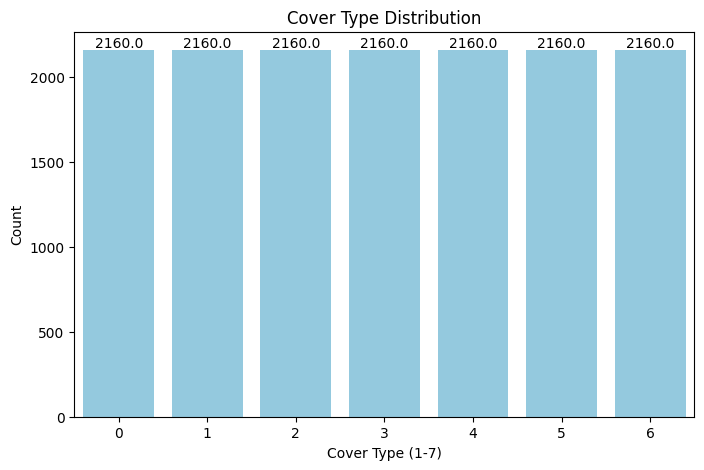

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Target Variable Distribution
plt.figure(figsize=(8, 5))
ax = sns.countplot(x="Cover_Type", data=data, color="skyblue")

# Add value labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height),  # position at center of bar
                ha='center', va='bottom', fontsize=10, color='black')

plt.title("Cover Type Distribution")
plt.xlabel("Cover Type (1-7)")
plt.ylabel("Count")
plt.show()

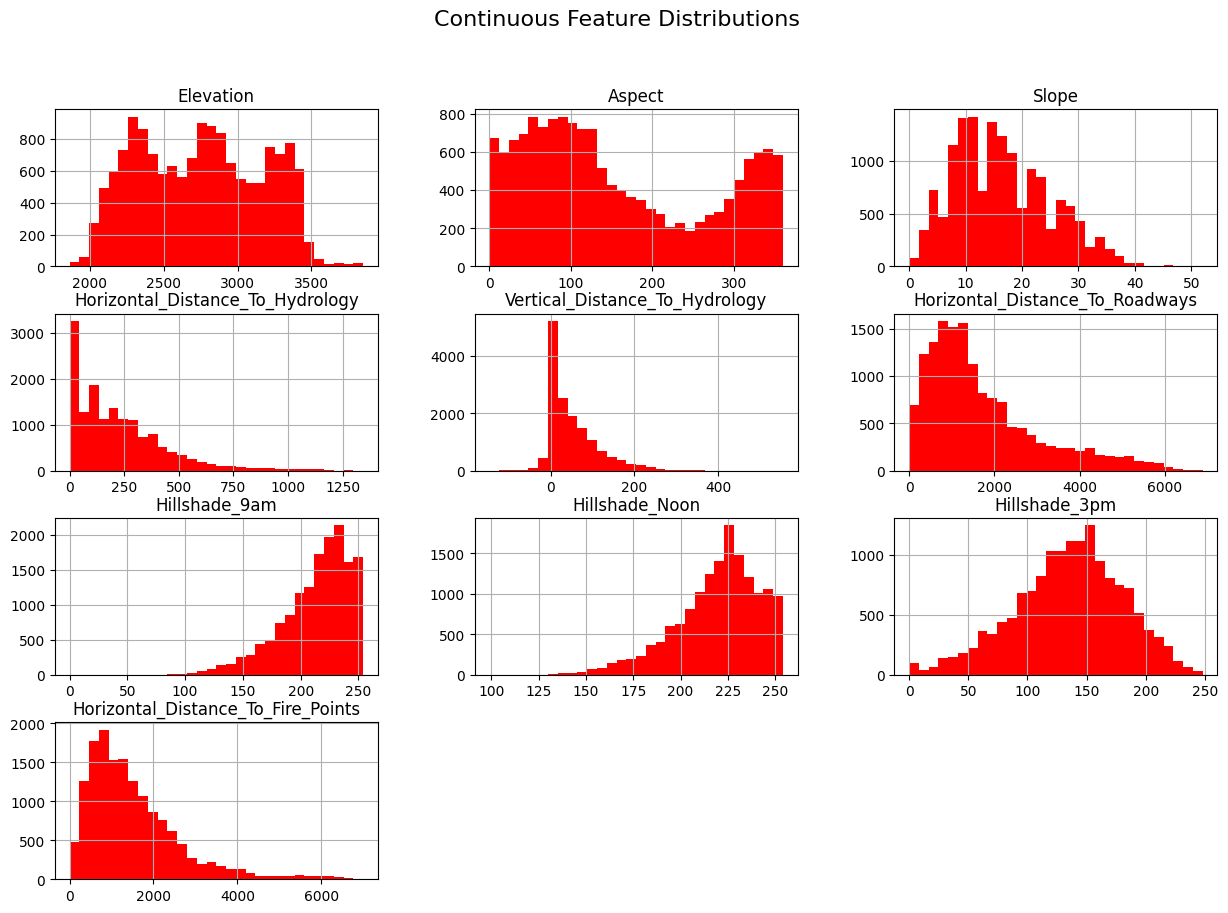

In [16]:
# Continuous Feature Distributions
continuous_features = ['Elevation', 'Aspect', 'Slope',
                       'Horizontal_Distance_To_Hydrology',
                       'Vertical_Distance_To_Hydrology',
                       'Horizontal_Distance_To_Roadways',
                       'Hillshade_9am', 'Hillshade_Noon',
                       'Hillshade_3pm',
                       'Horizontal_Distance_To_Fire_Points']

data[continuous_features].hist(figsize=(15, 10), bins=30, color="red")
plt.suptitle("Continuous Feature Distributions", fontsize=16)
plt.show()

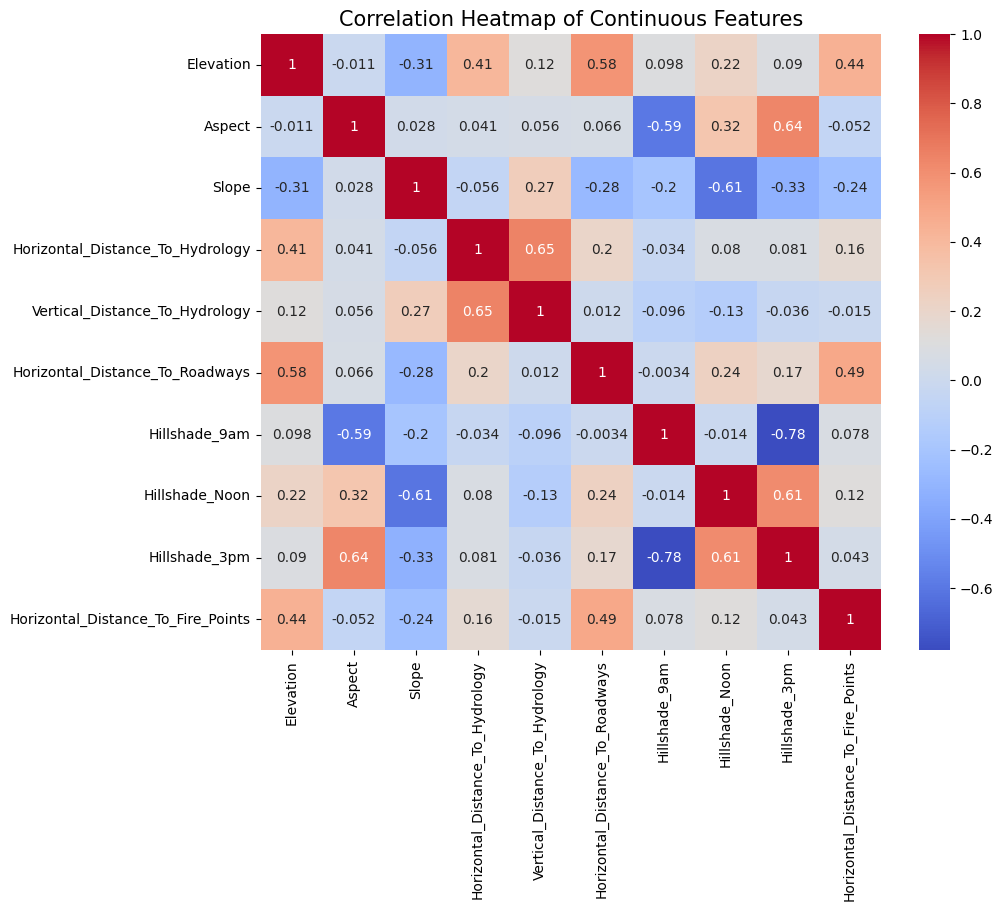

In [17]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data[continuous_features].corr(), annot = True, cmap = 'coolwarm')
plt.title("Correlation Heatmap of Continuous Features", fontsize=15)
plt.show()

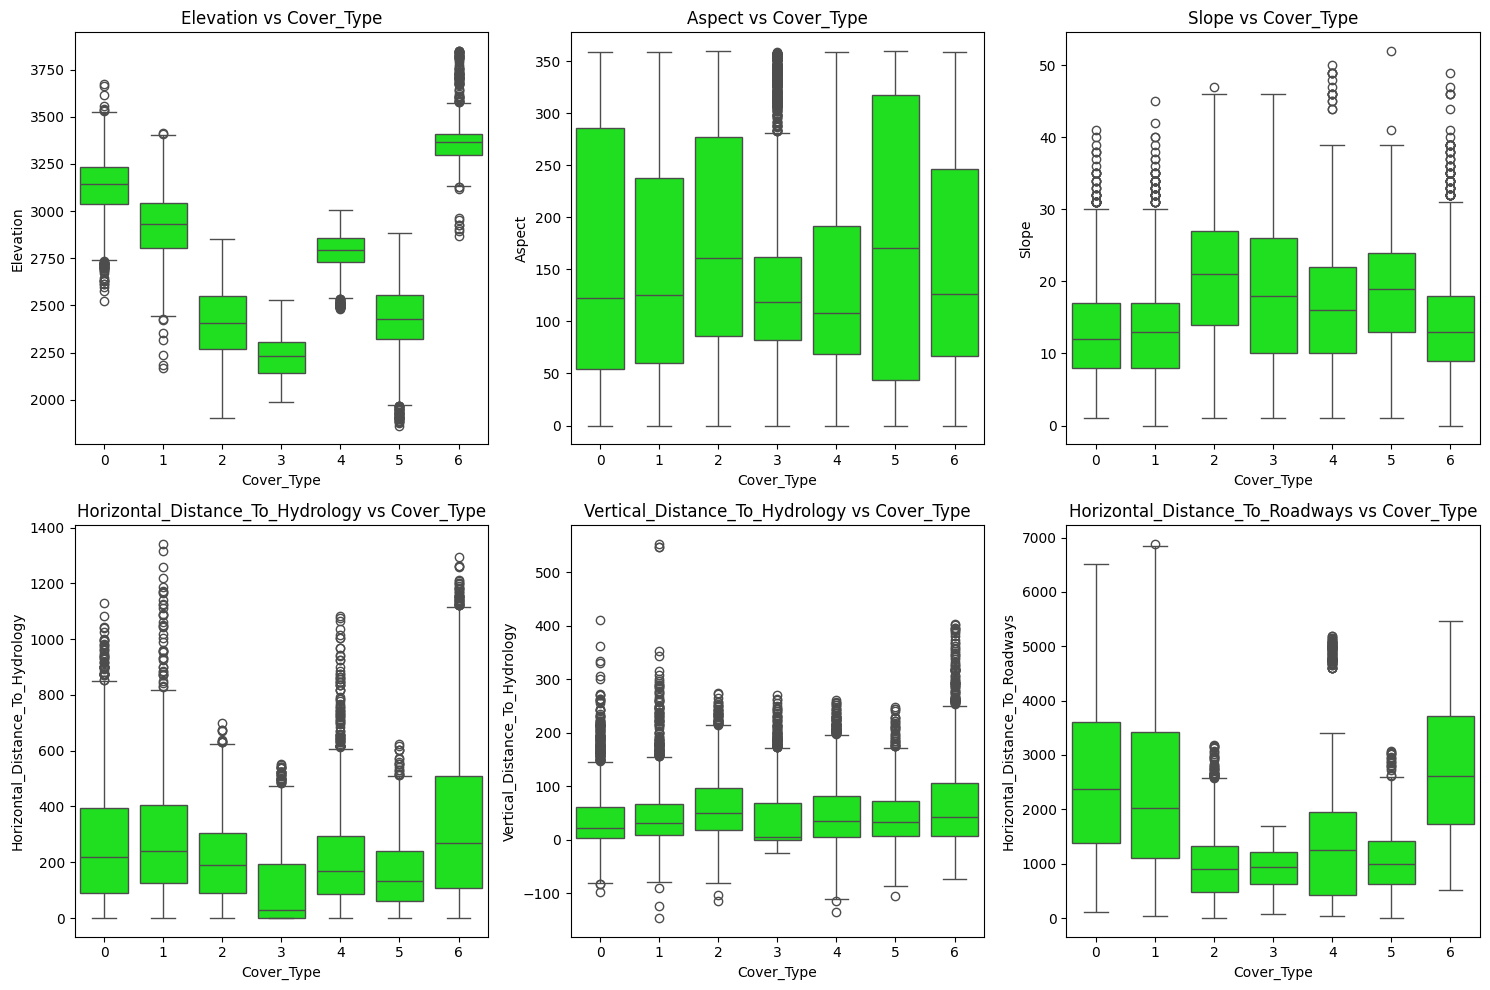

In [18]:
# Boxplots of Key Features vs Cover Type
target = 'Cover_Type'

plt.figure(figsize=(15, 10))
for i, feature in enumerate(continuous_features[:6]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x = target, y = feature, data = data, color="lime")
    plt.title(f"{feature} vs Cover_Type")
plt.tight_layout()
plt.show()

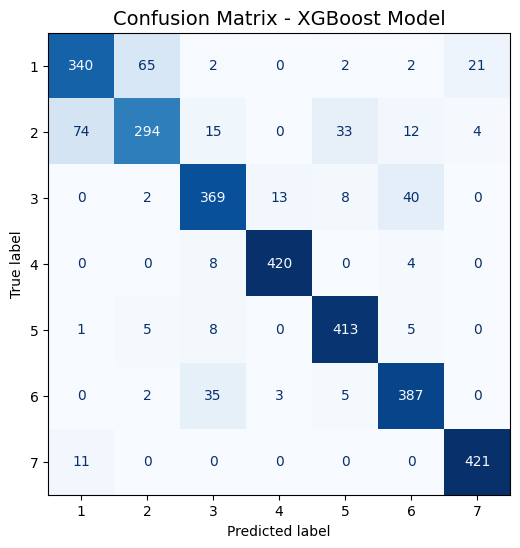

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Shift both predictions and true labels back from 0-6 → 1-7
y_pred_shifted = xgb_model.predict(X_test) + 1
y_test_shifted = y_test + 1

# Confusion matrix
cm = confusion_matrix(y_test_shifted, y_pred_shifted, labels=[1, 2, 3, 4, 5, 6, 7])

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5, 6, 7])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Confusion Matrix - XGBoost Model", fontsize=14)
plt.show()


In [20]:
from sklearn.metrics import classification_report, accuracy_score

# Shift predictions and labels back to 1-7 for reporting
y_pred_shifted = xgb_model.predict(X_test) + 1
y_test_shifted = y_test + 1

# Classification report
print("=== XGBoost Classification Report ===")
print(classification_report(y_test_shifted, y_pred_shifted, digits=3))

# Overall Accuracy
accuracy = accuracy_score(y_test_shifted, y_pred_shifted)
print(f"✅ Model Accuracy: {accuracy:.4f}")

=== XGBoost Classification Report ===
              precision    recall  f1-score   support

           1      0.798     0.787     0.793       432
           2      0.799     0.681     0.735       432
           3      0.844     0.854     0.849       432
           4      0.963     0.972     0.968       432
           5      0.896     0.956     0.925       432
           6      0.860     0.896     0.878       432
           7      0.944     0.975     0.959       432

    accuracy                          0.874      3024
   macro avg      0.872     0.874     0.872      3024
weighted avg      0.872     0.874     0.872      3024

✅ Model Accuracy: 0.8743


In [21]:
# Get feature importance
feature_importance = pd.Series(
    xgb_model.feature_importances_,
    index=xgb_model.get_booster().feature_names
).sort_values(ascending=False)

# Display top 10 features
print("=== Top 10 Features ===")
print(feature_importance.head(10))

=== Top 10 Features ===
Soil_Type30         0.090920
Elevation           0.087720
Soil_Type3          0.076677
Soil_Type10         0.062925
Wilderness_Area4    0.059464
Soil_Type13         0.047021
Soil_Type39         0.040074
Soil_Type4          0.037319
Soil_Type22         0.035597
Soil_Type12         0.035104
dtype: float32


C:\Users\karme\AppData\Local\Temp\ipykernel_25940\3643195124.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


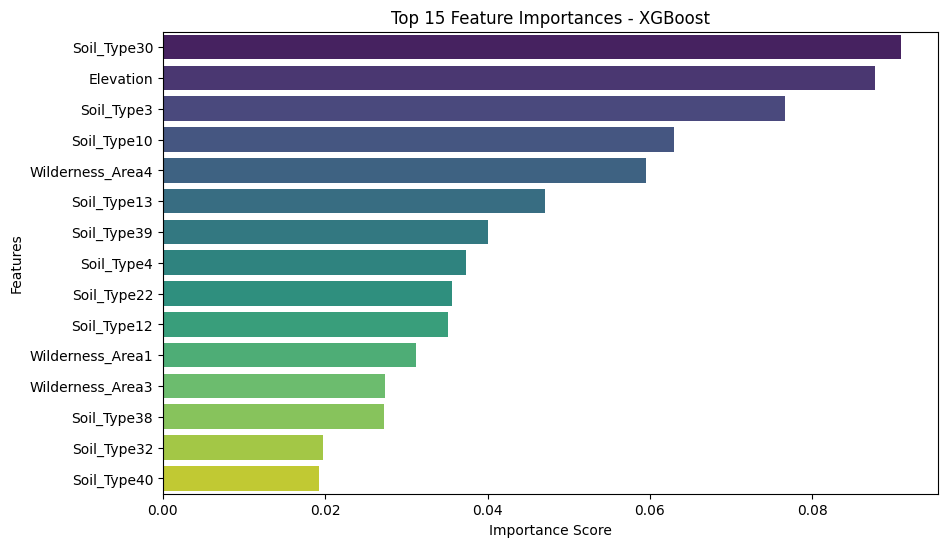

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=feature_importance.values[:15],
    y=feature_importance.index[:15],
    palette="viridis"
)
plt.title("Top 15 Feature Importances - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

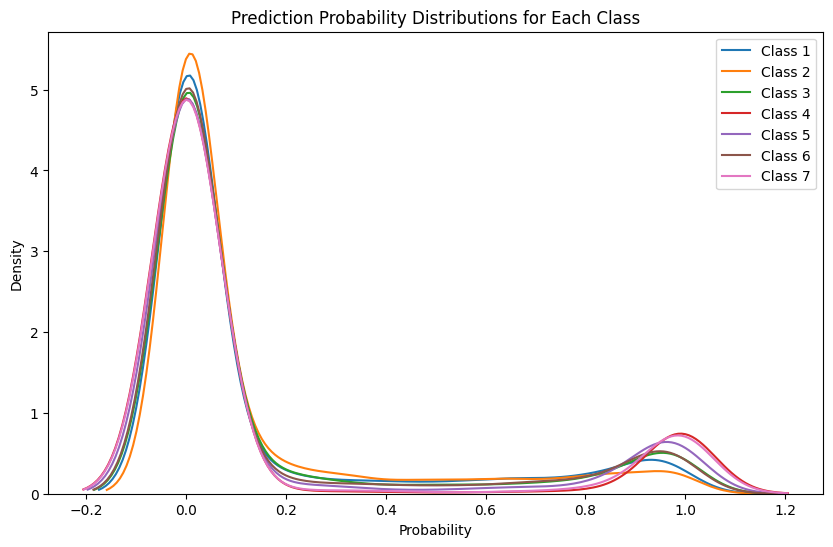

In [23]:
# Predict probability for each class
y_probs = xgb_model.predict_proba(X_test)

plt.figure(figsize=(10, 6))
for i in range(y_probs.shape[1]):  # Loop over classes
    sns.kdeplot(y_probs[:, i], label=f"Class {i+1}")

plt.title("Prediction Probability Distributions for Each Class")
plt.xlabel("Probability")
plt.ylabel("Density")
plt.legend()
plt.show()

Total Misclassified Samples: 380 / 3024


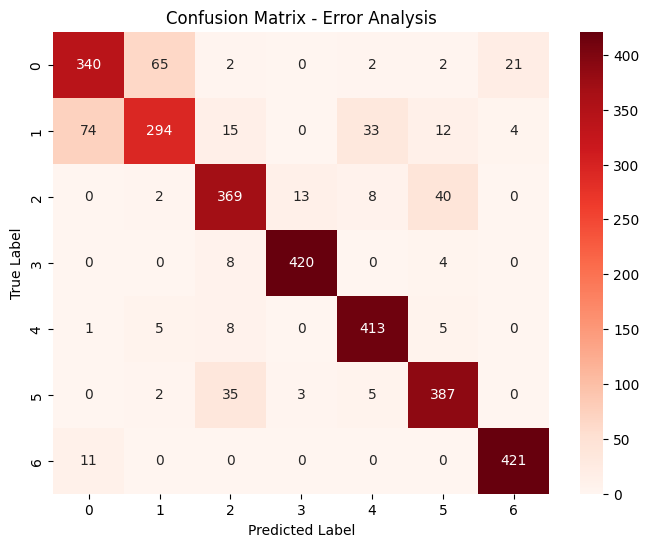

In [24]:
# Find misclassified samples
misclassified = X_test[y_pred_shifted != y_test_shifted]
print(f"Total Misclassified Samples: {len(misclassified)} / {len(y_test_shifted)}")

# Plot a confusion matrix heatmap for errors
cm = confusion_matrix(y_test_shifted, y_pred_shifted, labels=[1,2,3,4,5,6,7])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix - Error Analysis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

C:\Users\karme\AppData\Local\Temp\ipykernel_25940\2748395520.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(support.keys()), y=list(support.values()), palette="Blues_r")


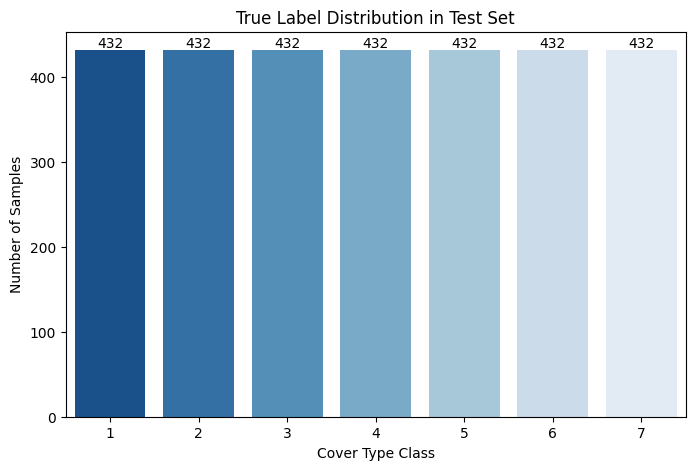

In [37]:
from collections import Counter

# Show how many samples per class in test data
support = Counter(y_test_shifted)

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=list(support.keys()), y=list(support.values()), palette="Blues_r")

# Add value labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height),  # position at center of bar
                ha='center', va='bottom', fontsize=10, color='black')

plt.title("True Label Distribution in Test Set")
plt.xlabel("Cover Type Class")
plt.ylabel("Number of Samples")
plt.show()

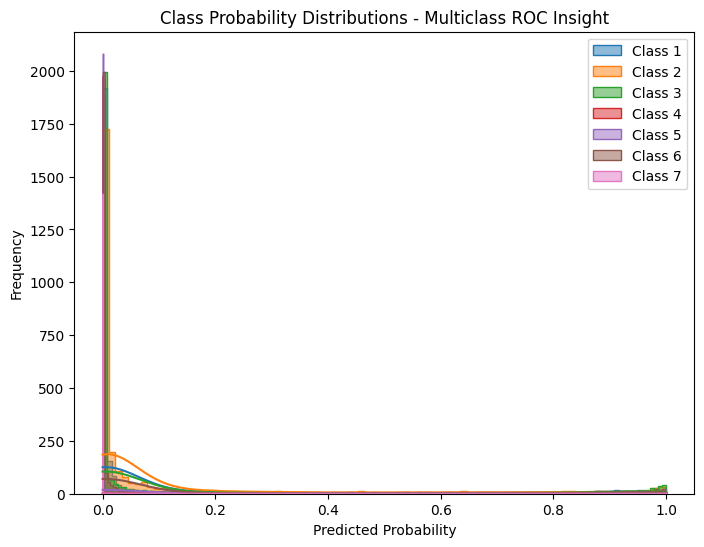

In [26]:
from sklearn.preprocessing import label_binarize

# Binarize the true labels for ROC
y_test_bin = label_binarize(y_test_shifted, classes=[1,2,3,4,5,6,7])

plt.figure(figsize=(8, 6))
for i in range(7):
    sns.histplot(y_probs[:, i], kde=True, label=f"Class {i+1}", element="step")

plt.title("Class Probability Distributions - Multiclass ROC Insight")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()

C:\Users\karme\AppData\Local\Temp\ipykernel_25940\1562706190.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


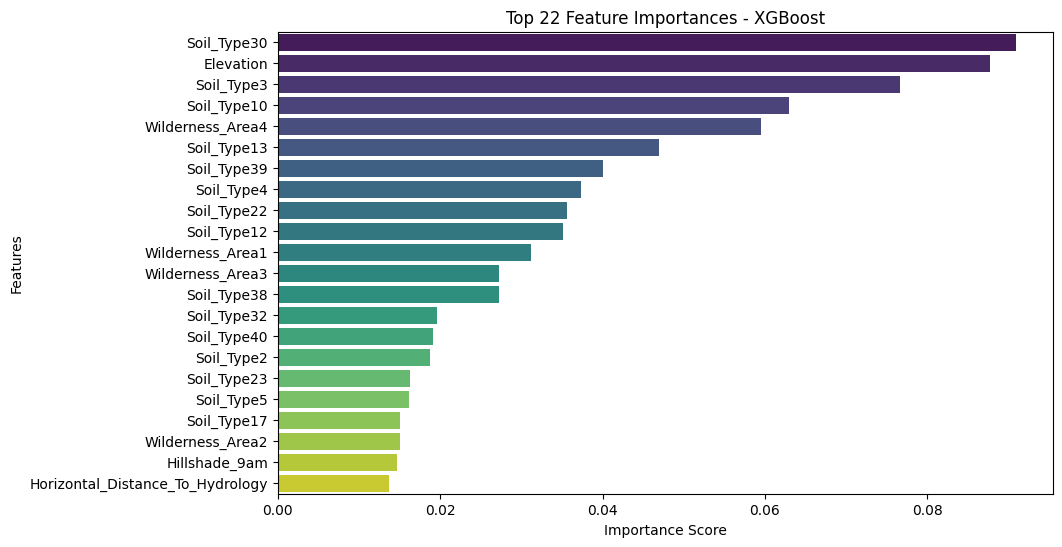

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=feature_importance.values[:22],
    y=feature_importance.index[:22],
    palette="viridis"
)
plt.title("Top 22 Feature Importances - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()